# Exercise sheet 4

Practice problems for coursework II.

In [7]:
using Plots
using SparseArrays
using LinearAlgebra

## *Method of lines*

Write a program that evolves the **advection equation**

$$
    \partial_t u + c \partial_x u = 0
$$

For initial conditions $u(0, x) = f(x)$. Suppose $f(x) = \exp(-16x^2)$

In [8]:
f(x) = exp(-16x^2)

f (generic function with 1 method)

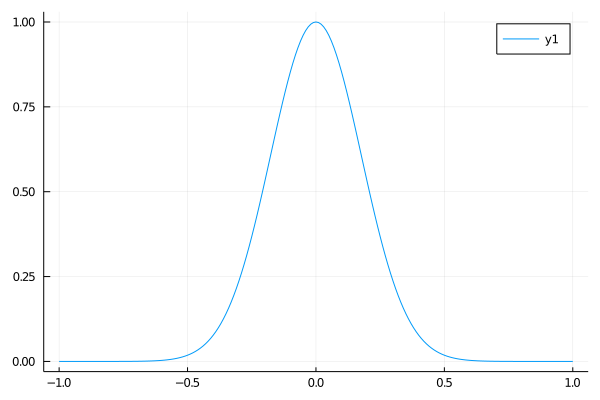

In [9]:
Δt = 0.01
trange = -1:Δt:1
plot(trange, f.(trange))

We will discretize the pde as follows

$$
\frac{d{\bf u}}{dt} = c \mathbb{D}{\bf u}
$$

Which implies that the change in the system becomes

$$
{\bf u}(t_{n+1}) - {\bf u}(t_{n}) = \int_{t_n}^{t_{n+1}} \mathbb{D}{\bf u}(t) dt
$$

In [10]:
"""
# Build a differentiation matrix

This function builds a differentiation matrix required to compute
a second-order finite-differences method assuming equidistant points
"""
function build_diff_matrix(x_grid, Δx)
    n_grid = length(x_grid)
    D = spzeros(n_grid, n_grid)
    
    for row in 1:n_grid
        if row == 1
            # Left-difference formula
            D[row, row] = -3
            D[row, row + 1] = 4
            D[row, row + 2] = -1
        elseif row == n_grid
            # Right-difference formula
            D[row, row - 2] = 1
            D[row, row - 1] = -4
            D[row, row] = 3
        else
            # Central-difference formula
            D[row, row - 1] = -1
            D[row, row] = 0
            D[row, row + 1] = 1
        end
    end
    
    D = D ./ 2Δx
    return D
end


"""
# 2nd order finite-differences

Compute the 2nd order difference's method 
assuming a set of equidistant points
"""
function finite_differences(f, x_grid, Δx)
    D = build_diff_matrix(x_grid, Δx)
    fvals = f.(x_grid)
    f_prime_approx = D * fvals
    
    return f_prime_approx
end

finite_differences

#### A small review: finite-differences

In order to compute the derivative using the 2nd-order finite-differences' method, we only require to compute the *fixed* derivative matrix $D$ and evaluate the set of observed points at the given function

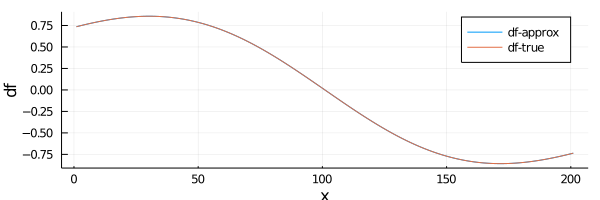

In [11]:
f(x) = exp(-x ^ 2.0)
f_prime(x) = -2.0 * exp(-x ^ 2.0)x

f_prime_vals = finite_differences(f, trange, Δt)
f_prime_true = f_prime.(trange)

plot(f_prime_vals, label="df-approx", size=(600, 200))
plot!(f_prime_true, label="df-true", ylabel="df", xlabel="x")

----

### TVD-RK2

$$
    u(0, x) = f(x)
$$

In [29]:
f(x) = exp(-16x^2)

f (generic function with 1 method)

In [39]:
c = 1
Δt = 0.01
xrange = -1:Δt:1
nvals = length(xrange)
D = build_diff_matrix(xrange, Δt)
D[[end], :] .= 0
L = c * D
M = I + Δt * L + Δt ^ 2 / 2 * L ^ 2;

In [40]:
U_old = f.(xrange)
nsteps = 100
U_matrix = zeros(nsteps, nvals)

U_matrix[1, :] = U_old
for ti=2:nsteps
    U_new = M * U_old
    U_matrix[ti, :] = U_new
    U_old = U_new
end

U_matrix;

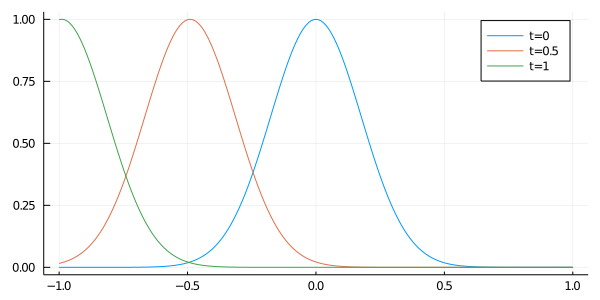

In [41]:
plot(xrange, U_matrix[1, :], label="t=0", size=(600, 300))
plot!(xrange, U_matrix[50, :], label="t=0.5")
plot!(xrange, U_matrix[100, :], label="t=1")

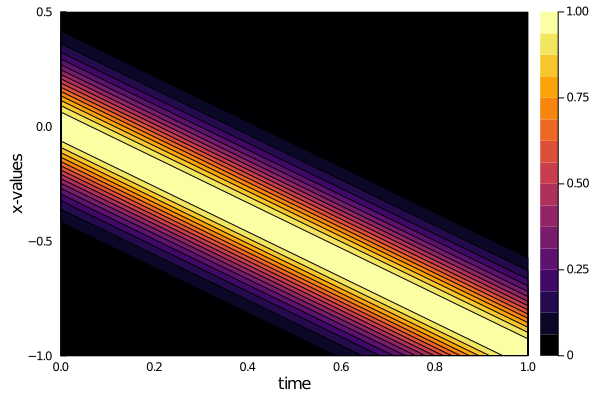

In [42]:
contourf(range(0, 1, length=100), xrange, transpose(U_matrix), xlabel="time", ylabel="x-values", ylim=(-1, 0.5))

### Trapezium rule

In [24]:
c = 1
Δt = 0.01
xrange = -1:Δt:1
nvals = length(xrange)
D = build_diff_matrix(xrange, Δt)
D[[end], :] .= 0 
L = c * D
M = I + Δt * L + Δt ^ 2 * L ^ 2;

In [25]:
M0 = I - Δt * L / 2 + (Δt ^ 2) * L ^ 2
M1 = I + Δt * L / 2 + (Δt ^ 2) * L ^ 2;

In [26]:
function trapezium_integrate(nsteps, xrange, f, M0, M1)
    U_old = f.(xrange)
    nvals = length(xrange)
    U_matrix = zeros(nsteps, nvals)
    
    U_matrix[1, :] = U_old
    for ti=2:nsteps
        # Efficient only for finite-differences
        U_new = M0 \ (M1 * U_old)
        U_matrix[ti, :] = U_new
        U_old = U_new
    end
    
    return U_matrix
end

trapezium_integrate (generic function with 1 method)

In [27]:
nsteps = 100
t_max = Δt * nsteps

U_trapezium = trapezium_integrate(nsteps, xrange, f, M0, M1)

100×201 Array{Float64,2}:
 1.12535e-7  1.54728e-7  2.12059e-7  …  2.12059e-7  1.54728e-7  1.12535e-7
 1.51362e-7  2.08331e-7  2.83805e-7     1.58065e-7  1.33111e-7  1.12535e-7
 2.02966e-7  2.79214e-7  3.79331e-7     1.38163e-7  1.24064e-7  1.12535e-7
 2.7202e-7   3.73464e-7  5.05972e-7     1.25793e-7  1.18714e-7  1.12535e-7
 3.63905e-7  4.98424e-7  6.73566e-7     1.20392e-7  1.16132e-7  1.12535e-7
 4.8597e-7   6.6383e-7   8.94768e-7  …  1.16613e-7  1.14482e-7  1.12535e-7
 6.47632e-7  8.82225e-7  1.18609e-6     1.15104e-7  1.13713e-7  1.12535e-7
 8.61292e-7  1.16996e-6  1.56884e-6     1.13799e-7  1.13157e-7  1.12535e-7
 1.14296e-6  1.54815e-6  2.07054e-6     1.13424e-7  1.12936e-7  1.12535e-7
 1.51345e-6  2.04407e-6  2.72659e-6     1.1291e-7   1.12731e-7  1.12535e-7
 1.99959e-6  2.69282e-6  3.58242e-6  …  1.12868e-7  1.12679e-7  1.12535e-7
 2.63598e-6  3.53945e-6  4.69613e-6     1.12628e-7  1.12592e-7  1.12535e-7
 3.46702e-6  4.64162e-6  6.14187e-6     1.12677e-7  1.12592e-7  1.12535e-7

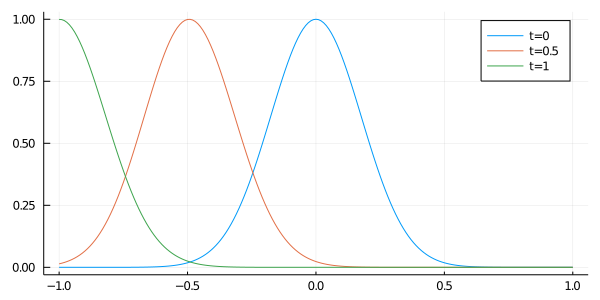

In [28]:
plot(xrange, U_trapezium[1, :], label="t=0", size=(600, 300))
plot!(xrange, U_trapezium[50, :], label="t=0.5")
plot!(xrange, U_trapezium[100, :], label="t=1")

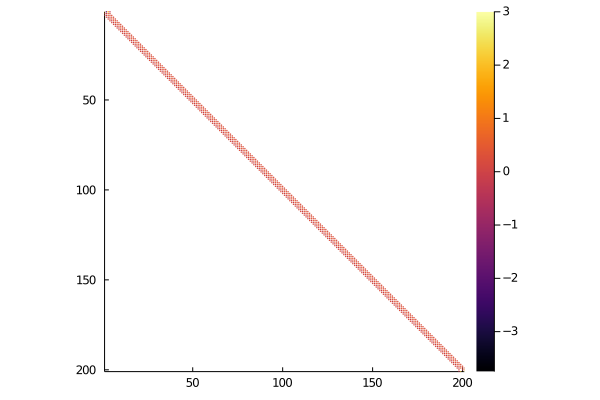

In [21]:
spy(M1)

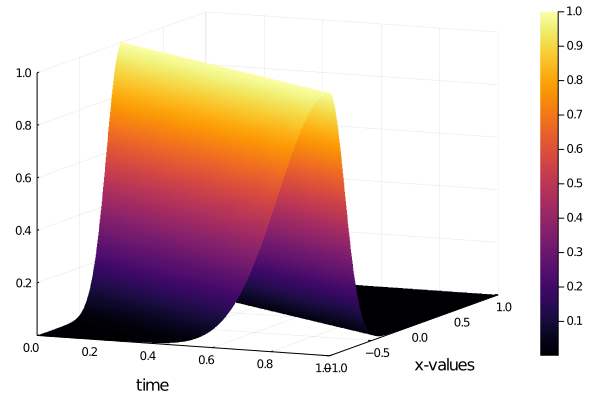

In [22]:
trange = range(0, t_max, length=nsteps)
surface(trange, xrange, transpose(U_trapezium), xlabel="time", ylabel="x-values")

* What exactly is the Pade approximation
* For schrödinger's eq, det(H) = 1. Why do we care about symmetry or anti-simeetry?